# Urbanization Index Comparisons with GHS <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene), 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2),
[ls_usgs_fc_scene](https://explorer.digitalearth.africa/ls_usgs_fc_scene)

## Background
There are many different urbanization indices with different characteristics and use cases. It is often convenient to be able to compare the performance of several  indicies for an area - determining which is the best for an area based on the outputs and a "ground truth" dataset of urbanization.

## Description

This notebook uses several indices to classify land as "urban" and then compares those results with the Global Human Settlement (GHS) product (https://ghsl.jrc.ec.europa.eu/ghs_bu2019.php) which calculates built-up area (urban extent) up through 2014. The indices tested here include Normalized Difference Buildup Index (NDBI), Fractional Cover (FC), and the Enhanced Normalized Difference Impervious Surface Index (ENDISI). 

The notebook selects a region of interest and a time window for the year-2014. A geomedian cloud-filtered mosaic is created for the year and images are then created for each index using the mosaic. In addition, a set of histograms is also created for each index. The user then selects a minimum and maximum threshold value for each index to identify potential urban pixels. Those output products are then shown. The choice and adjustment of the threshold values is supported by the histogram plots and the output comparisons with the GHS dataset (more below).

Next, the GHS dataset is loaded for the region of interest and the urban extent is shown for the year 2014. Finally, the urban extent products from each of the 3 indices is compared with the GHS product and the accuracy is evaluated. The code will calculate the true/false positive/negative sums and calculate values for a typical confusion matrix to assess the results. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial.

1. Select a region of interest.
2. Create a cloud-filtered median mosaic with data for the year 2014.
3. Show histograms for the indicies.
4. Select minimum and maximum threshold values for the indicies to determine urban pixels.
5. Show the urbanization prediction images.
6. Load and show the "ground truth" data (GHS) for the year 2014.
7. Compare the urbanization predictions with the "ground truth" data visually and statistically.

The choice of threshold values can be informed by the histograms and comparing the urbanization prediction images with the "ground truth" urbanization data.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys

import datacube
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import numpy as np
import xarray as xr
import pandas as pd
from collections import namedtuple

sys.path.append("../Scripts")
from deafrica_dask import create_local_dask_cluster
from deafrica_datahandling import calc_geomedian, load_ard, mostcommon_crs, wofs_fuser
from deafrica_plotting import display_map#, rgb
from deafrica_bandindices import calculate_indices

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel.
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:35863 Dashboard: /user/jcrattz/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="Urbanization_GHS_Comparison")

### Analysis parameters

The following cell sets important parameters for the analysis. The parameters are:

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `lat_buffer`: The number of degrees to load around the central latitude.
* `lon_buffer`: The number of degrees to load around the central longitude.
* `time_range`: The time range to analyze - in YYYY-MM-DD format (e.g. `('2016-01-01', '2016-12-31')`).

**If running the notebook for the first time**, keep the default settings below.
The default area is Dakar, Senegal.

**To run the notebook for a different area**, make sure Landsat 8 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa).
Use the drop-down menu to check Landsat 8 (`ls8_usgs_sr_scene`).

#### Suggested areas
Here are some suggestions for areas to look at. To view one of these areas, copy and paste the parameter values into the cell below, then run the notebook.

**Dodoma, Tanzania**
```
lat = -6.1696
lon = 35.748
lat_buffer = 0.0356
lon_buffer = 0.036
```

**Dar es Salam, Tanzania**
```
lat = -6.8205
lon = 39.219
lat_buffer = 0.1505
lon_buffer = 0.129
```

**Nairobi, Kenya**
```
lat = -1.28
lon = 36.85
lat_buffer = 0.12
lon_buffer = 0.15
```

**Kumasi, Ghana**
```
lat =  6.7012
lon = -1.60825
lat_buffer = 0.1722
lon_buffer = 0.18715
```

**Dakar, Senegal**
```
lat = 14.72
lon = -17.355
lat_buffer = 0.19
lon_buffer = 0.215
```

### Select location

In [4]:
# Define the area of interest
lat = 14.72
lon = -17.355
lat_buffer = 0.19
lon_buffer = 0.215

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Time period
time_range = ("2014-01-01", "2014-12-31")

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
# The code below renders a map that can be used to view the region.
display_map(lon_range, lat_range)

## Load the data
We can use the [load_ard](Using_load_ard.ipynb) function to load data from multiple satellites (i.e. Landsat 7 and Landsat 8), and return a single `xarray.Dataset`.

In [6]:
# Create the 'query' dictionary object, which contains the longitudes,
# latitudes and time provided above
product = "ls8_usgs_sr_scene"
query = {
    "longitude": lon_range,
    "latitude": lat_range,
    "time": time_range,
    "resolution": (-0.00027, 0.00027),
    "align": (0.000135, 0.000135),
    "dask_chunks": {'time': 1, 'longitude': 2000, 'latitude': 2000},
    "group_by": "solar_day",
}

# Identify the most common projection system in the input query
output_crs = 'EPSG:4326'#mostcommon_crs(dc=dc, product=product, query=query)
query.update({'output_crs': output_crs})

# Load available data
landsat_dataset = load_ard(
    dc=dc,
    products=[product],
    measurements=["red", "green", "blue", "swir1", "swir2", "nir"],
    min_gooddata=0.0,
    **query
)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 40 time steps as a dask array


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` attribute revels the number of time steps in the data set, as well as the number of pixels in the `longitude` and `latitude` dimensions.

In [7]:
landsat_dataset

,Array,Chunk
Bytes,358.87 MB,8.97 MB
Shape,"(40, 1408, 1593)","(1, 1408, 1593)"
Count,301 Tasks,40 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,358.87 MB,8.97 MB
Shape,"(40, 1408, 1593)","(1, 1408, 1593)"
Count,301 Tasks,40 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


**Filter out water pixels and create a geomedian mosaic**

In [8]:
# Create a water mask using WOfS.
water = dc.load(
    product=["ga_ls8c_wofs_2"],
    fuse_func=wofs_fuser, **query).water
water = water.sel(time=landsat_dataset.time, method='nearest')
water = water.isin([128,130,160,162,192])
water['longitude'] = landsat_dataset.longitude
water['latitude'] = landsat_dataset.latitude
# Mask out water.
water_mask = water.mean('time') > 0.1
land_dataset = landsat_dataset.where(~water_mask)
# Create the geomedian composite.
land_composite = calc_geomedian(land_dataset, min_value=0, max_value=10000).persist()

## Land Fractional Cover  

Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. We use a model from CSIRO (Juan Gerschmann) and apply it to the land composite. The components of the FC product are: Bare Soil (bs), Photosynthetic Vegetation (pv), Non Photosynthetic Vegetation (npv)

The FC false color output product uses RGB = bs/pv/npv
<br>RED = Bare Soil or Urban Areas
<br>BLUE = Non-Green Vegetation
<br>GREEN = Green Vegetation
<br>BLACK = Water

In [9]:
frac_classes = dc.load(
    product=["ls_usgs_fc_scene"], 
    measurements = ["BS", "PV", "NPV"],
    **query)
frac_classes = frac_classes.sel(time=landsat_dataset.time, method='nearest')
frac_classes['longitude'] = landsat_dataset.longitude
frac_classes['latitude'] = landsat_dataset.latitude
frac_classes_composite = calc_geomedian(frac_classes, min_value=0, max_value=100).persist()
frac_classes_composite = frac_classes_composite.where(~water_mask)

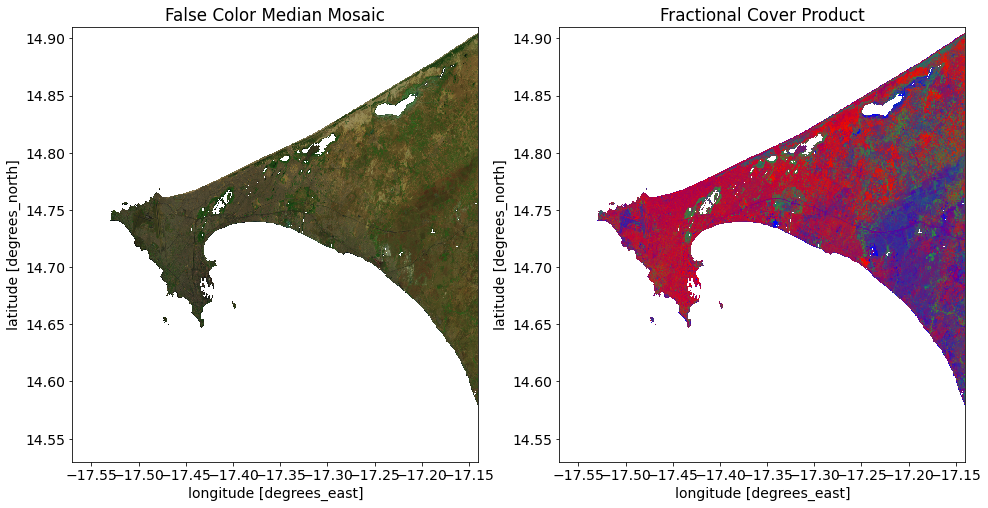

In [10]:
from deafrica_plotting import rgb

fig, ax = plt.subplots(1, 2, figsize=(16,8))

rgb(land_composite, ['swir2', 'nir', 'green'], ax=ax[0], vmin=0, vmax=10000)
rgb(frac_classes_composite, ['BS', 'PV', 'NPV'], ax=ax[1], vmin=0, vmax=100)
ax[0].set_title('False Color Median Mosaic')
ax[1].set_title('Fractional Cover Product')
plt.show()

## Land Spectral Indices

We're going to be calculating NDBI and ENDISI as urbanization indices.

> ### NDBI
The Normalized Difference Built-Up Index (NDBI) is one of the most commonly used proxies of urbanization. Like all normalized difference indicies, it has a range of \[-1,1\].

$$
\begin{aligned}
\text{NDBI} = \frac{\text{SWIR1} - \text{NIR}}{\text{SWIR1} + \text{NIR}}
\end{aligned}
$$

> ### ENDISI
The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) is a more recently developed urbanization proxy. Like all normalized difference indicies, it has a range of \[-1,1\].
Note that `MNDWI`, `swir_diff` and `alpha` are all part of the ENDISI calculation.

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{GREEN} - \text{SWIR1}}{\text{GREEN} + \text{SWIR1}}
\end{aligned}
$$

$$
\begin{aligned}
\text{swir_diff} = \frac{\text{SWIR1}}{\text{SWIR2}}
\end{aligned}
$$

$$
\begin{aligned}
\text{alpha} = \frac{\text{2*mean(BLUE)}}{\text{mean(swir_diff) + mean(MNDWI^2)}}
\end{aligned}
$$

$$
\begin{aligned}
\text{ENDISI} = \frac{\text{BLUE} - \text{alpha}*(\text{swir_diff} + \text{MNDWI^2})}
{\text{BLUE} + \text{alpha}*(\text{swir_diff} + \text{MNDWI^2})}
\end{aligned}
$$

In [11]:
def MNDWI(dataset):
    return calculate_indices(dataset, index='MNDWI', collection='c1').MNDWI
def Swir_diff(dataset):
    return dataset.swir1/dataset.swir2
def Alpha(dataset):
    return (2*(np.mean(dataset.blue)))/(np.mean(Swir_diff(dataset)) + np.mean(MNDWI(dataset)**2))
def ENDISI(dataset):
    mndwi = MNDWI(dataset)
    swir_diff = Swir_diff(dataset)
    alpha = Alpha(dataset)
    return (dataset.blue - (alpha)*(swir_diff + mndwi**2))/(dataset.blue + (alpha)*(swir_diff + mndwi**2))

In [12]:
land_composite = calculate_indices(land_composite, index='NDBI', collection='c1')
land_composite['ENDISI'] = ENDISI(land_composite)

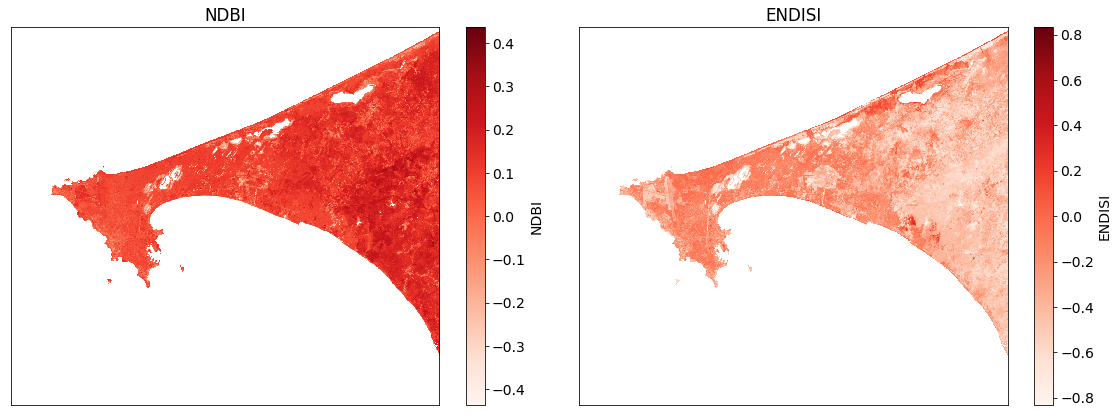

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
(land_composite.NDBI).plot.imshow(ax=ax[0],cmap = "Reds")
(land_composite.ENDISI).plot.imshow(ax=ax[1],cmap = "Reds")
ax[0].set_title('NDBI'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('ENDISI'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

## Determining the thresholds for urbanization
These histogram plots show the distribution of values for each product.
The urban threshold values are chosen using these histograms.

If a highly urban area is being examined, there should be visible maximal values for these histograms. The ideal thresholds should usually include these values (see the x axes of the histograms) and some range of values less than and greater than these maximal values.

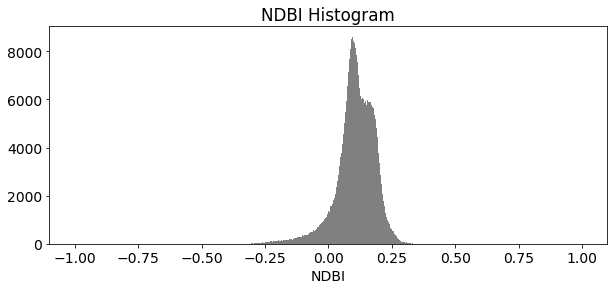

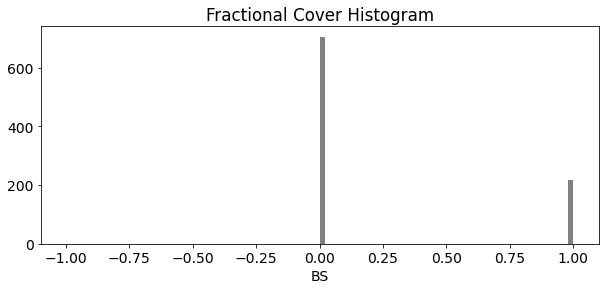

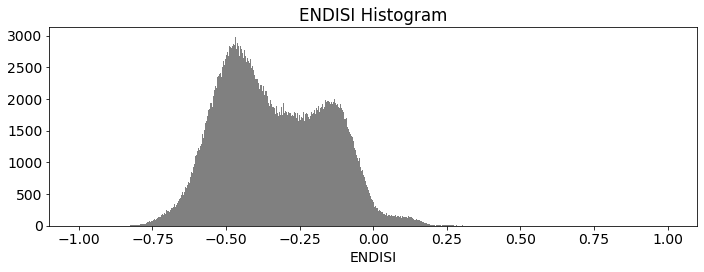

In [14]:
land_composite.NDBI.plot.hist(bins=1000, range=(-1,1), facecolor='gray', figsize=(10, 4))
plt.title('NDBI Histogram')
frac_classes_composite.BS.plot.hist(bins=100, range=(-1,1), facecolor='gray', figsize=(10, 4))
plt.title('Fractional Cover Histogram')
land_composite.ENDISI.plot.hist(bins=1000, range=(-1,1), facecolor='gray', figsize=(10, 4))
plt.title('ENDISI Histogram')

plt.tight_layout()
plt.show()

## Create Threshold Plots
First we will define a minimum threshold and a maximum threshold for each index. Then we will create plots that color the threshold region a single color (e.g. red).

In [15]:
from matplotlib.ticker import FuncFormatter
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes

def threshold_plot(ds, da, min_threshold, max_threshold, 
                   mask = None, filter_size=1, 
                   fig = None, ax = None):
    """
    Creates a threshold plot.
    
    Parameters
    ----------
    ds: xarray.Dataset
        A 2D dataset to use as the background. Must have a swir1 data variable.
    da: xarray.DataArray
        A 2D dataarray for which to paint where `min_threshold < da < max_threshold`.
    min_threshold, max_threshold: numeric
        The min and max threshold values.
    mask: np.ndarray
        A boolean mask denoting where the data should be ignored (unclean, missing, etc.).
    filter_size: int
        The largest number of contiguous pixels inside or outside the threshold to filter
        based on their surrounding pixels. The default should be fine.
    fig, ax
        The matplotlib figure and axes to use.
    """
    # Define the colors (RGB) to be used for pixels inside the threshold range (`color_in`)
    # and pixels to be ignored as specified by `mask` (`color_cloud`).
    color_in    = np.array([1,0,0])
    color_cloud = np.array([1,1,1])
    
    # Create the RGB array - defaults to a black canvas.
    rgb_arr = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside = (min_threshold < da.values) & (da.values < max_threshold)
    inside = remove_small_objects(inside, min_size=filter_size+1, connectivity=2)
    inside = remove_small_holes(inside, area_threshold=filter_size+1, connectivity=2)
    masked = np.zeros(da.values.shape).astype(bool) if mask is None else mask

    # Color background
    rgb_arr[:] = np.repeat(ds['swir1'].values[:, :, np.newaxis], 3, axis=2)
    min_rgb, max_rgb = ds['swir1'].values.min(), ds['swir1'].values.max()
    rgb_arr = np.interp(rgb_arr, (0, 10000), [0,1])
    rgb_arr = rgb_arr.astype(float)
    # Color inside
    rgb_arr[inside] = color_in
    # Color masked
    rgb_arr[masked] = color_cloud
    ax_im = ax.imshow(rgb_arr)

    ax.set_title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    
    return ax_im

In [16]:
# NDBI (Buildup Index) = -1.0 to 1.0 (full range)
# NDBI -0.1 to 0.3 is typical for urban areas
min_ndbi_threshold = -0.1
max_ndbi_threshold = 0.125

# ENDISI = -1.0 to 1.0 (full range)
# ENDISI -0.2 to 0.4 is typical for urban areas
min_endisi_threshold = -0.3
max_endisi_threshold = 0.1

# Fractional Cover (pv,npv,bs) = 0 to 100
# Bare Soil (bs) 30 to 100 is typical for urban areas
min_fc_threshold = 50.0
max_fc_threshold = 80.0

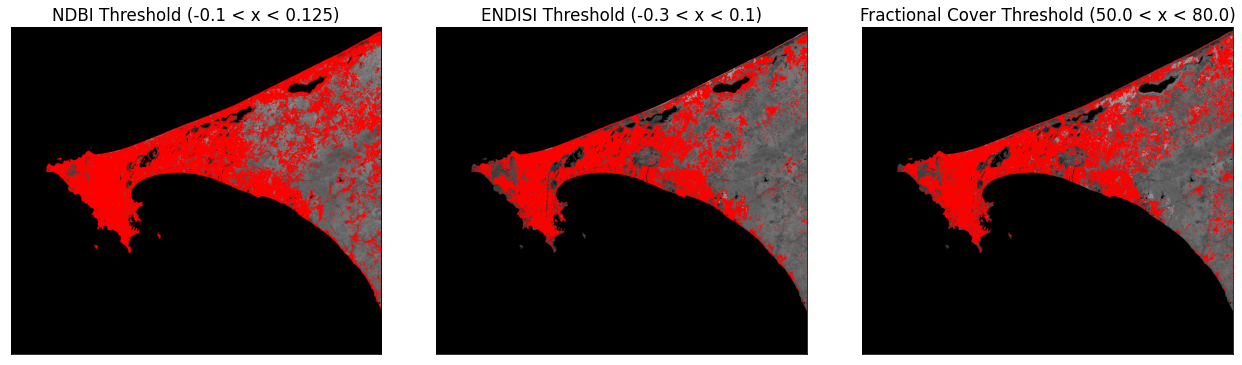

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

plt1 = threshold_plot(land_composite, land_composite.NDBI, min_ndbi_threshold, max_ndbi_threshold, ax=ax[0])
plt2 = threshold_plot(land_composite, land_composite.ENDISI, min_endisi_threshold, max_endisi_threshold, ax=ax[1])
plt3 = threshold_plot(land_composite, frac_classes_composite.BS, min_fc_threshold, max_fc_threshold, ax=ax[2])

ax[0].set_title(f'NDBI Threshold ({min_ndbi_threshold} < x < {max_ndbi_threshold})')
ax[0].xaxis.set_visible(False); ax[0].yaxis.set_visible(False)
ax[1].set_title(f'ENDISI Threshold ({min_endisi_threshold} < x < {max_endisi_threshold})')
ax[1].xaxis.set_visible(False); ax[1].yaxis.set_visible(False)
ax[2].set_title(f'Fractional Cover Threshold ({min_fc_threshold} < x < {max_fc_threshold})')
ax[2].xaxis.set_visible(False); ax[2].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

## Comparison Metrics
We will compare the performance of the urban index results against the GHS GeoTIFF product (shown below).

In [18]:
# Southern Ghana
# tif = 'GHS_data/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_13_11.tif'

# Kenya
# tif = 'GHS_data/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_11.tif'

# Tanzania
# tif = 'GHS_data/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_12.tif'

# Senegal
tif = 'GHS_data/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_10.tif'

ghs_ds = xr.open_rasterio(tif).squeeze() # Remove unneeded dimension.
ghs_ds.attrs['crs'] = ghs_ds.crs.replace('+init=', '')

In [19]:
from datacube.utils.geometry import assign_crs
from rasterio.warp import transform

# First convert GHS CRS to the same CRS as the landsat data.
x, y = transform(ghs_ds.crs, {'init': output_crs},
                 ghs_ds['x'].values.flatten(), ghs_ds['y'].values.flatten())

In [20]:
ghs_ds['x'] = x; ghs_ds['y'] = y
ghs_ds = ghs_ds.rename({'x':'longitude', 'y':'latitude'})
ghs_ds.attrs['crs'] = output_crs

# Subset the GHS data to the same area as the Landsat data.
ghs_ds = ghs_ds.sel(longitude=land_composite.longitude, 
                    latitude=land_composite.latitude, method='nearest')
ghs_ds['longitude'] = landsat_dataset.longitude
ghs_ds['latitude'] = landsat_dataset.latitude

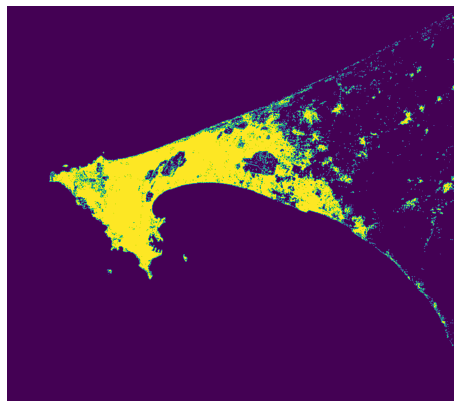

In [21]:
actual = (ghs_ds >= 3) & (ghs_ds <= 6)
fig = plt.figure(figsize=(8,8))
plt.imshow(actual)
plt.axis('off')
plt.show()

## Metric and Plotting Functions
The code below will calculate the true/false positive/negative sums and calculate values for a typical confusion matrix to assess the results. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Accuracy} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$

In [22]:
def get_metrics(actual, predicted, minimum_threshold, maximum_threshold, filter_size=1):
    """ Creates performance metrics.
    
    Args:
        actual: the data to use as truth.
        predicted: the data to predict and to compare against actual.
        minimum_threshold: the minimum threshold to apply on the predicted values for generating a boolean mask.
        maximum_threshold: the maximum threshold to apply on the predicted values for generating a boolean mask.
        filter_size: the filter size to apply on predicted to remove small object/holes with.
        
    Returns: A namedtuple containing the actual, predicted mask, and varying metrics for a confusion matrix.
    """
    metrics = namedtuple('Metrics',
                         'actual predicted true_positive true_negative false_positive false_negative')

    predicted  = (predicted > minimum_threshold) & (predicted < maximum_threshold)
    predicted  = remove_small_objects(predicted, min_size=filter_size+1, connectivity=2)
    predicted  = remove_small_holes(predicted, area_threshold=filter_size+1, connectivity=2)

    true_positive=(predicted & actual).sum()
    true_negative=(~predicted & ~actual).sum()
    false_positive=(predicted & ~actual).sum()
    false_negative=(~predicted & actual).sum()

    return metrics(actual=actual,
                   predicted=predicted,
                   true_positive=true_positive,
                   true_negative=true_negative,
                   false_positive=false_positive,
                   false_negative=false_negative)

def print_metrics(metrics):
    norm = metrics.true_positive + metrics.false_negative + metrics.false_positive + metrics.true_negative
    accuracy = (metrics.true_positive + metrics.true_negative)/norm
    ppv = metrics.true_positive/(metrics.true_positive + metrics.false_positive)
    tpr = metrics.true_positive/(metrics.true_positive + metrics.false_negative)
    f1 = (2*ppv*tpr)/(ppv+tpr)
    
    print('True Positive (Actual + Model = Urban): {tp}'.format(tp=round(metrics.true_positive/norm*100,3)))
    print('True Negative (Actual + Model = Non-Urban): {tn}'.format(tn=round(metrics.true_negative/norm*100,3)))
    print('False Positive (Actual=Non-Urban, Model=Urban): {fp}'.format(fp=round(metrics.false_positive/norm*100,3)))
    print('False Negative (Actual=Urban, Model=Non-Urban): {fn}'.format(fn=round(metrics.false_negative/norm*100,3)))
    print('\nAccuracy: {accuracy}'.format(accuracy=round(accuracy*100, 3)))
    print('F1 Score: {f1}\n'.format(f1=round(f1*100, 3)))

In [23]:
print ('\033[1m' + '\033[91m' + 'NDBI - Comparison Results') # bold print and red
print ('\033[0m') # stop bold and red
ndbi_metrics = get_metrics(actual.values, land_composite.NDBI.values, min_ndbi_threshold, max_ndbi_threshold)
print_metrics(ndbi_metrics)

NDBI - Comparison Results

True Positive (Actual + Model = Urban): 8.501
True Negative (Actual + Model = Non-Urban): 83.581
False Positive (Actual=Non-Urban, Model=Urban): 6.829
False Negative (Actual=Urban, Model=Non-Urban): 1.089

Accuracy: 92.082
F1 Score: 68.225



In [24]:
print ('\033[1m' + '\033[91m' + 'ENDISI - Comparison Results') # bold print and red
print ('\033[0m') # stop bold and red
endisi_metrics = get_metrics(actual.values, land_composite.ENDISI.values, min_endisi_threshold, max_endisi_threshold)
print_metrics(endisi_metrics)

ENDISI - Comparison Results

True Positive (Actual + Model = Urban): 7.447
True Negative (Actual + Model = Non-Urban): 86.951
False Positive (Actual=Non-Urban, Model=Urban): 3.459
False Negative (Actual=Urban, Model=Non-Urban): 2.143

Accuracy: 94.398
F1 Score: 72.667



In [25]:
print ('\033[1m' + '\033[91m' + 'Fractional Cover Base Soil - Comparison Results') # bold print and red
print ('\033[0m') # stop bold and red
frac_bs_metrics = get_metrics(actual.values, frac_classes_composite.BS.values, min_fc_threshold, max_fc_threshold)
print_metrics(frac_bs_metrics)

Fractional Cover Base Soil - Comparison Results

True Positive (Actual + Model = Urban): 7.765
True Negative (Actual + Model = Non-Urban): 86.3
False Positive (Actual=Non-Urban, Model=Urban): 4.109
False Negative (Actual=Urban, Model=Non-Urban): 1.825

Accuracy: 94.066
F1 Score: 72.353



## Output Comparisons
The `dstack` calls provide the `imshow` calls with RGB array inputs. For each image, the first channel (red) is the actual (ground truth, GHS) values, and both the second and third channels (green, blue) are the predicted values (green + blue = cyan).

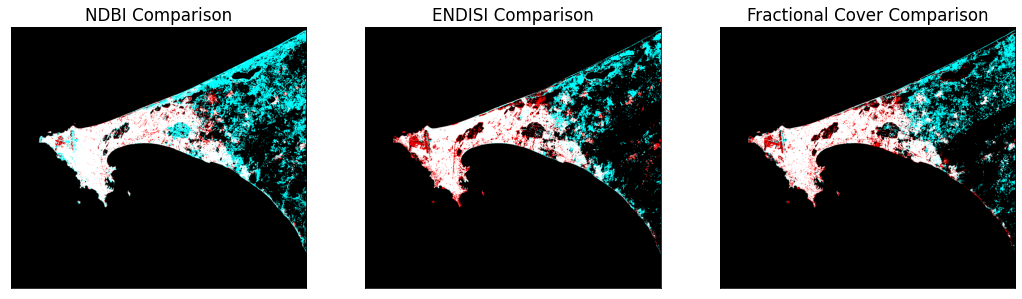

In [26]:
# Output Comparisons
# Black: Actual & Predicted No Urban (True Negative)
# Cyan: Predicted Urban (False Positive)
# Red: Actual Urban (False Negative)
# White: Actual & Predicted Urban (True Positive)

fig, ax = plt.subplots(1, 3, figsize=(18,6))

ax[0].imshow(np.dstack((ndbi_metrics.actual.astype(float),
                        ndbi_metrics.predicted.astype(float),
                        ndbi_metrics.predicted.astype(float))))
ax[1].imshow(np.dstack((endisi_metrics.actual.astype(float),
                        endisi_metrics.predicted.astype(float),
                        endisi_metrics.predicted.astype(float))))
ax[2].imshow(np.dstack((frac_bs_metrics.actual.astype(float),
                        frac_bs_metrics.predicted.astype(float),
                        frac_bs_metrics.predicted.astype(float))))

ax[0].set_title('NDBI Comparison'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('ENDISI Comparison'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
ax[2].set_title('Fractional Cover Comparison'), ax[2].xaxis.set_visible(False), ax[2].yaxis.set_visible(False)
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** July 2020

**Compatible datacube version:** 

In [27]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)

## See More
Machine learning can also be used to measure urbanisation. See [this notebook](../Real_world_examples/Machine_learning_with_ODC.ipynb) for a guide on using machine learning in the context of the ODC.